In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Пустых значений нет

In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Дубликатов нет

In [7]:
print("Дубликаты:", df.duplicated().sum())

Дубликаты: 0


### Количество уникальных значений в каждом столбце

In [8]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

### Отрицательные суммы отсутствуют

In [5]:
print("Отрицательные суммы:", (df['amount'] < 0).sum())

Отрицательные суммы: 0


### Мошеннические транзкции бывают только в CASH_OUT и TRANSFER

In [10]:
transaction_fraud = df.groupby("type")["isFraud"].sum().reset_index()
transaction_fraud

,type,isFraud
0,CASH_IN,0
1,CASH_OUT,4116
2,DEBIT,0
3,PAYMENT,0
4,TRANSFER,4097


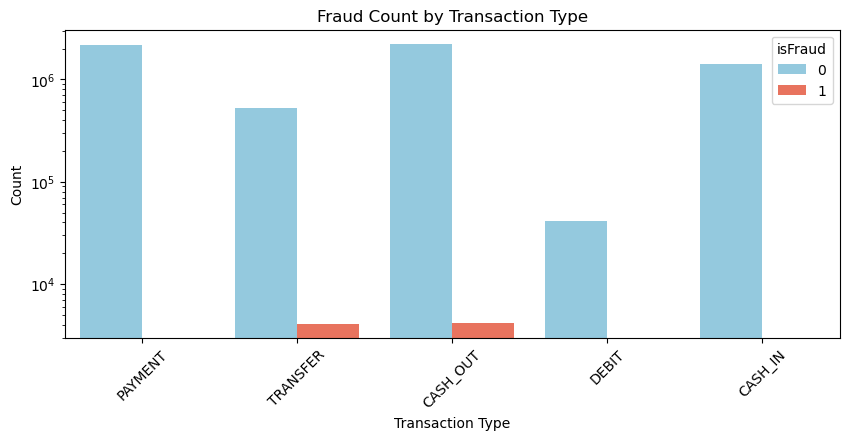

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(x='type', hue='isFraud', data=df, palette = {0: "skyblue", 1: "tomato"})
plt.yscale('log', base = 10)
plt.title('Fraud Count by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### На графике видно, что доля мошеннических транзакций крайне низкая, самый высокий показатель составил около 1% для транзакции 'TRANSFER'

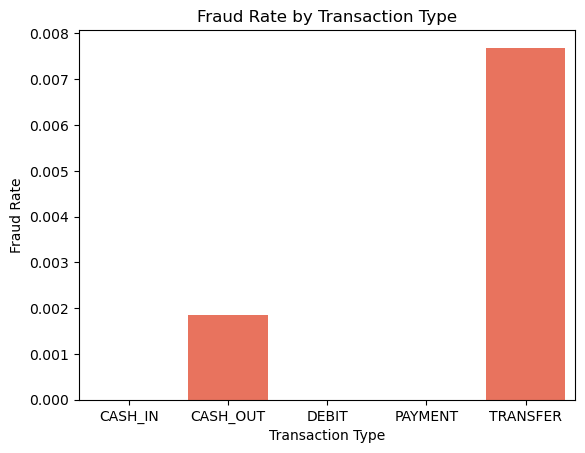

In [20]:
fraud_by_type = df.groupby('type')['isFraud'].mean()

sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, color = 'tomato')
plt.title("Fraud Rate by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

###  В двух записях у отправителя баланс после транзакции стал больше, чем до (не учитываем CASH_IN) на сумму транзакции.
### Удалять строки не стала, так как скорее всего это особенности генерации данных PaySim

In [11]:
mask = (df['type'] != 'CASH_IN') & (df['oldbalanceOrg'] < df['newbalanceOrig'])
df_invalid = df[mask]

print("Невалидных записей:", len(df_invalid))
df_invalid

Невалидных записей: 2


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
34076,8,CASH_OUT,88553.31,C319673957,67106.46,88553.31,C932634391,67106.46,0.00,0,0
34779,8,CASH_OUT,106659.84,C638668928,80084.58,106659.84,C224342296,80084.58,92322.89,0,0


### В 1198410 записях после TRANSFER и CASH_IN баланс у получателя стал меньше
### Удалять строки не стала, так как это может исказить аналитику по общему объёму транзакций, поведению клиентов, вычислению доли мошенничества

In [12]:
mask = ((df['type'].isin(['TRANSFER', 'CASH_IN'])) & (df['oldbalanceDest'] > df['newbalanceDest']))
df_invalid_dest = df[mask]

print("Невалидных записей по получателю:", len(df_invalid_dest))

Невалидных записей по получателю: 1198410


### 1769 айди, которые могут быть и отправителем, и получателем 

In [13]:
set_orig = set(df['nameOrig'])
set_dest = set(df['nameDest'])

common_accounts = set_orig & set_dest
len(common_accounts)

1769

### Переименовала колонки для удобства дальнейшей работы

In [6]:
df = df.rename(columns = {
    'step': 'step_id',
    'nameOrig': 'orig_client_id',
    'type': 'type_name',
    'oldbalanceOrg': 'old_balance_orig',
    'newbalanceOrig': 'new_balance_orig',
    'nameDest': 'dest_client_id',
    'oldbalanceDest': 'old_balance_dest',
    'newbalanceDest': 'new_balance_dest',
    'isFraud': 'is_fraud',
    'isFlaggedFraud': 'is_flagged_fraud'
})

### Начала создавать таблицы измерений

In [18]:
transaction_types = (df[['type_name']].drop_duplicates().reset_index(drop=True).rename(columns={'type': 'type_name'}))
transaction_types['type_id'] = transaction_types.index+1
transaction_types = transaction_types[['type_id', 'type_name']]

In [19]:
transaction_types

,type_id,type_name
0,1,PAYMENT
1,2,TRANSFER
2,3,CASH_OUT
3,4,DEBIT
4,5,CASH_IN


In [7]:
clients = pd.concat([df['orig_client_id'], df['dest_client_id']]).drop_duplicates().reset_index(drop=True)
clients = pd.DataFrame({'client_id': clients.index + 1,  
                        'client_name': clients})

In [8]:
clients.head()

,client_id,client_name
0,1,C1231006815
1,2,C1666544295
2,3,C1305486145
3,4,C840083671
4,5,C2048537720


In [9]:
print('Уникальных отправителей:', df['orig_client_id'].nunique())
print('Уникальных получателей:', df['dest_client_id'].nunique())
print('Всего уникальных клиентов:', pd.concat([df['orig_client_id'], df['dest_client_id']]).nunique())
print('Всего строк в фактах:', len(df))

Уникальных отправителей: 6353307
Уникальных получателей: 2722362
Всего уникальных клиентов: 9073900
Всего строк в фактах: 6362620


In [10]:
dates = pd.DataFrame({'step_id': df['step_id'].unique()}).sort_values('step_id').reset_index(drop=True)

dates['hour_of_day'] = ((dates['step_id'] - 1) % 24) + 1        # 1–24
dates['day_of_week'] = (( (dates['step_id'] - 1) // 24 ) % 7) + 1  # 1–7
dates['week_of_month'] = (dates['step_id'] - 1) // (24*7) + 1  # 1–5


In [284]:
dates.head()

,step_id,hour_of_day,day_of_week,week_of_month
0,1,1,1,1
1,2,2,1,1
2,3,3,1,1
3,4,4,1,1
4,5,5,1,1


In [11]:
dates.nunique()

step_id          743
hour_of_day       24
day_of_week        7
week_of_month      5
dtype: int64

### Добавляю в таблицу фактов информацию из таблиц измерений

In [ ]:
df = df.merge(transaction_types, on='type_name', how='left')

In [ ]:
df = df.drop(columns=['type_id_x'])

In [ ]:
df = df.drop(columns=['type_name'])

In [ ]:
df = df.rename(columns={'type_id_y': 'type_id'})

In [ ]:
df = df.merge(clients, left_on='orig_client_id', right_on='client_name', how='left')
df['orig_client_id'] = df['client_id'] 
df.head()

In [ ]:
df = df.merge(clients, left_on='dest_client_id', right_on='client_name', how='left')
df['dest_client_id'] = df['client_id'] 
df.head()

In [ ]:
df['orig_clent_id'].dtype, clients['client_name'].dtype

In [256]:
df.head()

,step_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_id,client_id_x,client_name_x,client_id_y,client_name_y,client_id,client_name
0,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,0,0,1,1,C1231006815,6353308,M1979787155,6353308,M1979787155
1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,0,0,1,2,C1666544295,6353309,M2044282225,6353309,M2044282225
2,1,181.00,3,181.0,0.00,6353310,0.0,0.0,1,0,2,3,C1305486145,6353310,C553264065,6353310,C553264065
3,1,181.00,4,181.0,0.00,6353311,21182.0,0.0,1,0,3,4,C840083671,6353311,C38997010,6353311,C38997010
4,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,0,0,1,5,C2048537720,6353312,M1230701703,6353312,M1230701703


In [258]:
df = df.drop(columns=['client_id_x', 'client_name_x', 'client_id_y', 'client_name_y', 'client_id', 'client_name'])

In [259]:
df.head()

,step_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_id
0,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,0,0,1
1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,0,0,1
2,1,181.00,3,181.0,0.00,6353310,0.0,0.0,1,0,2
3,1,181.00,4,181.0,0.00,6353311,21182.0,0.0,1,0,3
4,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,0,0,1


In [260]:
df = df.merge(dates, on='step_id', how='left')
df.head()

,step_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_id,hour_of_day,day_of_week,week_of_month
0,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,0,0,1,1,1,1
1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,0,0,1,1,1,1
2,1,181.00,3,181.0,0.00,6353310,0.0,0.0,1,0,2,1,1,1
3,1,181.00,4,181.0,0.00,6353311,21182.0,0.0,1,0,3,1,1,1
4,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,0,0,1,1,1,1


In [261]:
df = df.drop(columns=['hour_of_day', 'day_of_week', 'week_of_month'])

In [262]:
df.head()

,step_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,type_id
0,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,0,0,1
1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,0,0,1
2,1,181.00,3,181.0,0.00,6353310,0.0,0.0,1,0,2
3,1,181.00,4,181.0,0.00,6353311,21182.0,0.0,1,0,3
4,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,0,0,1


In [263]:
new_order = [
    'step_id', 'type_id', 'amount', 'orig_client_id', 'old_balance_orig',
    'new_balance_orig', 'dest_client_id', 'old_balance_dest', 'new_balance_dest', 'is_fraud', 'is_flagged_fraud']
df = df[new_order]
df.head()

,step_id,type_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,1,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,0,0
1,1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,0,0
2,1,2,181.00,3,181.0,0.00,6353310,0.0,0.0,1,0
3,1,3,181.00,4,181.0,0.00,6353311,21182.0,0.0,1,0
4,1,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,0,0


### Привела колонки к нужным типам

In [264]:
df.dtypes

step_id               int64
type_id               int64
amount              float64
orig_client_id       object
old_balance_orig    float64
new_balance_orig    float64
dest_client_id        int64
old_balance_dest    float64
new_balance_dest    float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

In [268]:
clients['client_name'] = clients['client_name'].astype('string')

In [269]:
transaction_types['type_name'] = transaction_types['type_name'].astype('string')

In [270]:
df['orig_client_id'] = df['orig_client_id'].astype('int')
df['is_fraud'] = df['is_fraud'].astype('bool')
df['is_flagged_fraud'] = df['is_flagged_fraud'].astype('bool')

In [271]:
df.dtypes

step_id               int64
type_id               int64
amount              float64
orig_client_id        int64
old_balance_orig    float64
new_balance_orig    float64
dest_client_id        int64
old_balance_dest    float64
new_balance_dest    float64
is_fraud               bool
is_flagged_fraud       bool
dtype: object

In [272]:
df.head()

,step_id,type_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,1,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,False,False
1,1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,False,False
2,1,2,181.00,3,181.0,0.00,6353310,0.0,0.0,True,False
3,1,3,181.00,4,181.0,0.00,6353311,21182.0,0.0,True,False
4,1,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,False,False


In [273]:
df['transaction_id'] = df.reset_index(drop=True).index

In [274]:
df.head()

,step_id,type_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,transaction_id
0,1,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,False,False,0
1,1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,False,False,1
2,1,2,181.00,3,181.0,0.00,6353310,0.0,0.0,True,False,2
3,1,3,181.00,4,181.0,0.00,6353311,21182.0,0.0,True,False,3
4,1,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,False,False,4


In [277]:
df = df[['transaction_id', 'step_id', 'type_id', 'amount', 'orig_client_id', 'old_balance_orig',
    'new_balance_orig', 'dest_client_id', 'old_balance_dest', 'new_balance_dest', 'is_fraud', 'is_flagged_fraud']]

In [278]:
df.head()

,transaction_id,step_id,type_id,amount,orig_client_id,old_balance_orig,new_balance_orig,dest_client_id,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,0,1,1,9839.64,1,170136.0,160296.36,6353308,0.0,0.0,False,False
1,1,1,1,1864.28,2,21249.0,19384.72,6353309,0.0,0.0,False,False
2,2,1,2,181.00,3,181.0,0.00,6353310,0.0,0.0,True,False
3,3,1,3,181.00,4,181.0,0.00,6353311,21182.0,0.0,True,False
4,4,1,1,11668.14,5,41554.0,29885.86,6353312,0.0,0.0,False,False


## Сохранила таблицу фактов и таблицы измерений 

In [279]:
fact_transactions = df

In [280]:
fact_transactions.to_csv('fact_transactions.csv', index=False)

In [281]:
clients.to_csv('clients.csv', index=False)

In [282]:
transaction_types.to_csv("transaction_types.csv", index=False)

In [283]:
dates.to_csv("dates.csv", index=False)